In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pretty display for notebooks
%matplotlib inline
from pprint import pprint

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import train_test_split, learning_curve, cross_validate, GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Alternative data
data = pd.read_csv('./exported_features/all_features.csv')
features_df = data.drop('id', axis=1).drop('revenue', axis=1)
target = data.revenue
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.2, random_state=42)

In [ ]:
data = pd.read_csv('../data/train.csv')
flo_genre = pd.read_csv('../data/flo_genre_feature.csv').drop('Unnamed: 0', axis=1)
flo_age = pd.read_csv('../data/flo_age_feature.csv').drop('Unnamed: 0', axis=1)
marcel_keywords = pd.read_csv('../data/marcel_features.csv').drop('Unnamed: 0', axis=1)

data['popularity'] = np.log1p(data.popularity)
data = data.merge(flo_genre, on=['id'], how='left').merge(marcel_keywords, on=['id'], how='left').merge(flo_age, on=['id'], how='left')

data.runtime = data.runtime.fillna(np.mean(data.runtime))

features = list(flo_genre.columns) + ['popularity', 'budget', 'has_top_keyword', 'runtime']
features.remove('id')

features_df = data[features]
target = data.revenue

X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.2, random_state=42)

reg = LinearRegression()
reg.fit(X_train, np.log1p(y_train))
y_pred = np.exp(reg.predict(X_test)) - 1
np.sqrt(mean_squared_log_error(y_test, y_pred))

In [3]:
# Define own scoring function
# because target is actually log(target)
def my_score(y_true, y_pred):
    '''
    Compute the RMSLE on the actual target values, not the log target
    '''
    if any(np.expm1(y_pred) < 0):
        return np.Infinity
    else:
        return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))
scoring_fnc = make_scorer(my_score)


# Define own scoring function
# because target is actually log(target)
# returns -error, because grid search maximizes the eval metric
def my_score_neg(y_true, y_pred):
    '''
    Compute the RMSLE on the actual target values, not the log target
    '''
    if any(np.expm1(y_pred) < 0):
        return -1 * np.Infinity
    else:
        return -1 * np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))
scoring_fnc_neg = make_scorer(my_score_neg)


def train_and_eval(model, X_train, y_train, scoring):
    cv_results = cross_validate(model, 
                                X_train, 
                                np.log1p(y_train), 
                                cv=10, 
                                scoring=scoring, 
                                return_train_score=True)
    
    mean_train = np.mean(cv_results['train_score'])
    mean_cv = np.mean(cv_results['test_score'])
    std_train = np.std(cv_results['train_score'])
    std_cv = np.std(cv_results['test_score'])

    result_summary = {
        'model': model,
        'mean_train_score': mean_train,
        'mean_cv_score': mean_cv,
        'std_train_score': std_train,
        'std_cv_score': std_cv
    }
    
    return result_summary

In [4]:
train_and_eval(reg, X_train, y_train)

NameError: name 'reg' is not defined

### Learning Curves

In [5]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure(figsize=(10,5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring_fnc)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [6]:
plot_learning_curve(reg, 'Learning Curve Linear Regression -> High Bias', X_train, np.log1p(y_train), cv=10, train_sizes=np.linspace(.1, 1.0, 10), ylim=(1.67, 2.7))

NameError: name 'reg' is not defined

### Gradient Boosting

{'model': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, n_iter_no_change=None, presort='auto',
              random_state=None, subsample=1.0, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False),
 'mean_train_score': 1.6647913683798152,
 'mean_cv_score': 1.9383790486234567,
 'std_train_score': 0.022985294033136736,
 'std_cv_score': 0.17127673786109718}

C:\Users\Dennis\Anaconda3\lib\site-packages\numpy\core\_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


<module 'matplotlib.pyplot' from 'C:\\Users\\Dennis\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

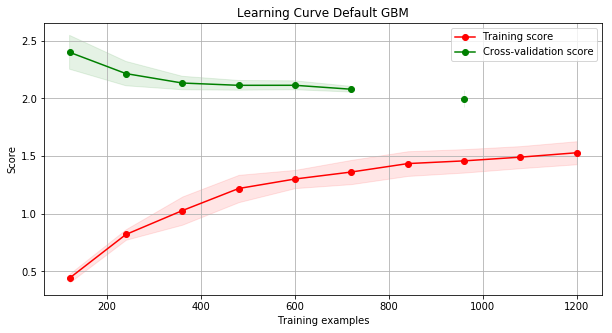

In [7]:
gb = GradientBoostingRegressor()
model=train_and_eval(gb, X_train, y_train, scoring_fnc)
display(model)
plot_learning_curve(gb, 'Learning Curve Default GBM', X_train, np.log1p(y_train), cv=2, train_sizes=np.linspace(.1, 1.0, 10))

#### Bayesian Optimization

In [8]:
import pandas as pd
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")

import lightgbm as lgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import roc_auc_score

In [9]:
#y_train = pd.read_csv('../input/application_train.csv')
#from sklearn.preprocessing import LabelEncoder
#def label_encoder(input_df, encoder_dict=None):
#    """ Process a dataframe into a form useable by LightGBM """
#    # Label encode categoricals
#    categorical_feats = input_df.columns[input_df.dtypes == 'object']
#    for feat in categorical_feats:
#        encoder = LabelEncoder()
#        input_df[feat] = encoder.fit_transform(input_df[feat].fillna('NULL'))
#    return input_df, categorical_feats.tolist(), encoder_dict
#y_train, categorical_feats, encoder_dict = label_encoder(y_train)
categorical_feats = features_df.columns.tolist()
print(categorical_feats)
X = X_train
y = y_train

['budgetlog', 'normalizedBudgetLog', 'popularitylog', 'budgetPop', 'runtime', 'Age', 'hasStar', 'NumStar', 'hashomepage', 'isinCollection', 'Action', 'Family', 'Adventure', 'History', 'Drama', 'Science Fiction', 'Romance', 'Fantasy', 'Horror', 'Animation', 'numberGenres']


In [24]:
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=42, n_estimators=10000, learning_rate=0.2, output_process=False):
    # prepare data
    train_data = lgb.Dataset(data=X, label=y, free_raw_data=False)
    #display(train_data)
    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        params = {'application':'binary','num_iterations':4000, 'learning_rate':learning_rate, 'early_stopping_round':100, 'metric':'auc'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lgb.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])

    # range 
    lgbBO = BayesianOptimization(lgb_eval, {'num_leaves': (24, 43),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 8.99),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 50)}, random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    display(lgbBO.max)
    return lgbBO.max_params

In [25]:
opt_params = bayes_parameter_opt_lgb(X, y, init_round=5, opt_round=10, n_folds=3, random_seed=6, n_estimators=100, learning_rate=0.05)
print(opt_params)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  1.0      |  0.9098   |  0.6722   |  3.014    |  1.635    |  6.69     |  34.07    |  0.04432  |  40.94    |
|  2        |  1.0      |  0.9927   |  0.4068   |  3.959    |  1.587    |  7.266    |  46.65    |  0.008033 |  25.66    |
|  3        |  1.0      |  0.804    |  0.7661   |  3.891    |  2.61     |  8.905    |  40.96    |  0.04669  |  38.83    |
|  4        |  1.0      |  0.8237   |  0.6119   |  0.7168   |  2.834    |  7.082    |  23.66    |  0.02719  |  38.71    |
|  5        |  1.0      |  0.8912   |  0.5547   |  0.09395  |  1.853    |  7.442    |  32.76    |  0.09443  |  36.95    |
|  6        |  1.0      |  0.846    |  0.5776   |  3.925    |  2.075    |  5.408    |  5.082    |  0.0886   |  24.18    |
|  7        |  1.0      

{'target': 1.0,
 'params': {'bagging_fraction': 0.909762700785465,
  'feature_fraction': 0.6721514930979355,
  'lambda_l1': 3.0138168803582195,
  'lambda_l2': 1.6346495489906907,
  'max_depth': 6.690382649362229,
  'min_child_weight': 34.065235087999525,
  'min_split_gain': 0.04432113391500656,
  'num_leaves': 40.94368701485952}}

AttributeError: 'BayesianOptimization' object has no attribute 'max_params'

In [17]:
# Learning rate
learning_rate = [0.01, 0.1, 0.15, 0.2]

# Number of trees
n_estimators = [100, 200, 300, 400, 500]

# Max Depth
max_depth = [1, 2, 3, 5]

# Create the random grid
param_grid = {'learning_rate': learning_rate,
                'n_estimators': n_estimators, 
                'max_depth': max_depth}

pprint(param_grid)

gb = GradientBoostingRegressor()
gb_grid = GridSearchCV(gb, param_grid=param_grid, cv=10, n_jobs=-1, verbose=2, scoring=scoring_fnc_neg)
gb_grid.fit(X_train, np.log1p(y_train))

{'learning_rate': [0.01, 0.1, 0.15, 0.2],
 'max_depth': [1, 2, 3, 5],
 'n_estimators': [100, 200, 300, 400, 500]}
Fitting 10 folds for each of 80 candidates, totalling 800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 261 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   49.3s
[Parallel(n_jobs=-1)]: Done 747 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:  1.5min finished
C:\Users\Dennis\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:791: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.1, 0.15, 0.2], 'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [1, 2, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=make_scorer(my_score_neg), verbose=2)

-2.2027470544474435


{'model': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.2, loss='ls', max_depth=2, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, n_iter_no_change=None, presort='auto',
              random_state=None, subsample=1.0, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False),
 'mean_train_score': 1.9745647016886536,
 'mean_cv_score': 2.2034068775359197,
 'std_train_score': 0.02755659060110186,
 'std_cv_score': 0.2391874700493635}

<module 'matplotlib.pyplot' from 'C:\\Users\\Dennis\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

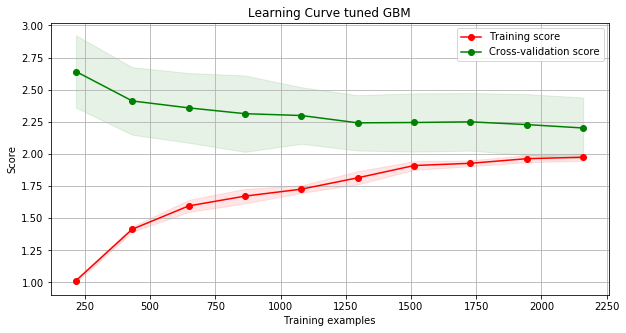

In [18]:
print(gb_grid.best_score_)
display(train_and_eval(gb_grid.best_estimator_, X_train, y_train, scoring_fnc))
plot_learning_curve(gb_grid.best_estimator_, 'Learning Curve tuned GBM', X_train, np.log1p(y_train), cv=10, train_sizes=np.linspace(.1, 1.0, 10))